In [3]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from sklearn import preprocessing # https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities
from snowflake.snowpark.functions import col

import getpass
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
#nj07294.ap-southeast-1

In [5]:
accountname = 'nj07294.ap-southeast-1'
#accountname = getpass.getpass() # ORGNAME-ACCOUNTNAME (separated by minus sign)

In [6]:
username ="VIBUV"    # SNOWFLAKE-USERNAME

In [7]:
password = "s10222756B"   # SNOWFLAKE-PASSWORD

In [8]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "FROSTBYTE_TASTY_BYTES",

    "warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()

In [25]:
def sales_growth():
    year_df=session.sql("  select year(ORDER_TS) as years,sum(oh.order_total) \
    from FROSTBYTE_TASTY_BYTES.RAW_POS.ORDER_HEADER oh \
    join RAW_POS.LOCATION lc on oh.location_id=lc.location_id \
    where lc.iso_country_code='US'\
    group by years\
    order by years;")

    array=year_df.collect()
    year_list=[]
    yoy_list=[]
    for i in  range(1,len(array)):
        diff=array[i][1]-array[i-1][1]
        percent=(diff/array[i-1][1])*100
        year_list.append(str(array[i][0]))
        yoy_list.append(percent)
    
    plt.plot(year_list,yoy_list)
    plt.ylabel('YOY% Growth')
    plt.xlabel("Year")
    
    for i in range(len(year_list)):
        plt.annotate(f'{yoy_list[i]:.0f}%', (year_list[i], yoy_list[i]), xytext=(1, 2),
                     textcoords='offset points')

    plt.show()
    


## Overview of Solution

 Before going into the technical deatails and the other info the end goal of the solution need to identified. Based on the buisness overview they were three goals that TastyByte wanted to achieve.They are 20% YoY growth in Sales and the number of trucks for the next 5 years. Along with a improvement in NPS from 3 to 40.

 The objective that the report would aims to achieving the goal of 20%YoY growth in Sales over the next 5 years. The chart below shows the YoY sales growth over the years of the buisness operation. From the chart it can be seen that the buisness expotianal growth in its first two year which have slow down to a 30% increaase in 2022 compared to 2021. Our solution aims to stabilise the YoY growth in sales by trying to improve sales generated by each truck.

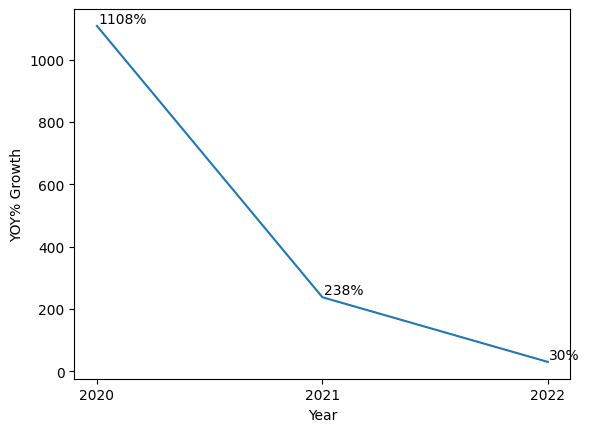

In [26]:

sales_growth()

In Order to maximise sale for each of the food truck , the pain points that prevent the truck to maximise their sales has to identified. Based on data , it was discovered that the movement of truck is rather not too costly in other word it is not profitable.Another possible pain point is about truck having limited storage space which can lead to lack of customer catering. The chart below shows sales earned per km travel. The metric allows to check how profitable movement of the truck is.


Based on the chart it can be seen that the profitablity of the truck movement has been rather stagnant. The solution that would be used to solve ths problem would be optimised routing. Optimised routing would not only increase the profitability of the movement , it could be also improve customer catering. This is because each truch which serve a particual menu would be directed to a location where the items would popular among the demographics there.

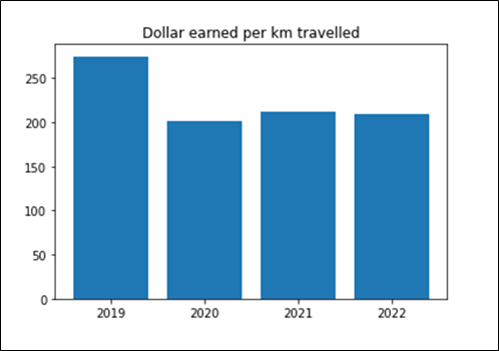

In [30]:
from IPython.display import Image, display
display(Image(filename='Picture1.png'))

# Transformation and Filtering

### Filter

We would be building a prototype for our model. As it is prototype, we do not want to use all the data as it would utilise too much computing resources and time , hence we are filtering it down to just united states which is the region with the highest number of sales.

In [135]:
sdf = session.table('ANALYTICS.ORDERS_V')
df=sdf.filter(col("COUNTRY")=='United States')

In [137]:
df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"PRIMARY_CITY"  |"REGION"  |"COUNTRY"      |"FRANCHISE_FLAG"  |"FRANCHISE_ID"  |"FRANCHISEE_FIRST_NAME"  |"FRANCHISEE_LAST_NAME"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"E_MAIL"  |"PHONE_NUMBER"  |"CHILDREN_COUNT"  |"GENDER"  |"MARITAL_STATUS"  |"MENU_ITEM_ID"  |"MENU_ITEM_NAME"   

In [ ]:
df=df.drop(['ORDER_DISCOUNT_AMOUNT','ORDER_TAX_AMOUNT','ORDER_AMOUNT','PRICE','UNIT_PRICE','QUANTITY','MENU_ITEM_NAME','MENU_ITEM_ID','MARITAL_STATUS','GENDER','CHILDREN_COUNT','PHONE_NUMBER','E_MAIL','LAST_NAME','FIRST_NAME','CUSTOMER_ID','FRANCHISEE_FIRST_NAME','FRANCHISEE_LAST_NAME','FRANCHISE_ID','FRANCHISE_FLAG','LINE_NUMBER','ORDER_ID'])

### Extract weather data

We would be first extracting weather data and then converted it into pandas. We would be using it later.

In [138]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "GLOBAL_WEATHER__CLIMATE_DATA_FOR_BI",

    "warehouse": "HOL_WH"
}

wea_session = Session.builder.configs(connection_parameters).create()
wdf = wea_session.table('STANDARD_TILE.HISTORY_DAY')

In [139]:
wdf.show()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [140]:
wdf2 = wdf.to_pandas()


In [141]:
wdf2.head()

,POSTAL_CODE,COUNTRY,DATE_VALID_STD,DOY_STD,MIN_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_AIR_2M_F,MAX_TEMPERATURE_AIR_2M_F,MIN_TEMPERATURE_WETBULB_2M_F,AVG_TEMPERATURE_WETBULB_2M_F,MAX_TEMPERATURE_WETBULB_2M_F,...,TOT_PRECIPITATION_IN,TOT_SNOWFALL_IN,TOT_SNOWDEPTH_IN,MIN_CLOUD_COVER_TOT_PCT,AVG_CLOUD_COVER_TOT_PCT,MAX_CLOUD_COVER_TOT_PCT,MIN_RADIATION_SOLAR_TOTAL_WPM2,AVG_RADIATION_SOLAR_TOTAL_WPM2,MAX_RADIATION_SOLAR_TOTAL_WPM2,TOT_RADIATION_SOLAR_TOTAL_WPM2
0,102103,NG,2021-08-19,231,73.7,77.4,84.6,72.5,73.6,75.1,...,0.16,0.0,0.0,20,88,100,0.0,149.9,668.7,3596.4
1,110054,IN,2021-08-19,231,76.9,87.4,100.1,73.2,76.8,80.9,...,0.01,0.0,0.0,37,77,100,0.0,269.6,927.2,6470.4
2,2044,AU,2021-08-19,231,49.4,59.3,67.4,48.0,53.0,56.3,...,0.00,0.0,0.0,3,46,96,0.0,167.1,688.0,4010.1
3,21745-690,BR,2021-08-19,231,65.7,74.0,86.1,63.6,66.9,71.8,...,0.00,0.0,0.0,0,2,7,0.0,235.5,822.0,5651.3
4,60596,DE,2021-08-19,231,57.9,62.7,66.3,57.2,60.3,62.6,...,0.03,0.0,0.0,75,97,100,0.0,59.9,196.1,1438.4


## Creating DateTime Variables

We converted the order_timestamp columns into something that is more managable. The first step is to create new columns for month day and hour. This is to allow the model to discover relationship between the target columns and the individual aspects of dates more easily. The second part is to create column for day of week and week of month. This is cause it may effect sales. e.g there could be sales on the weekend or more sales on the first after people reacieve their salary.


In [143]:
df=df.withColumn("Month",F.month(df["ORDER_TS"]))
df=df.withColumn("DOW",F.dayofweek(df["ORDER_TS"]))
df=df.withColumn("Day",F.dayofmonth(df["ORDER_TS"]))
df=df.withColumn("Hour",F.hour(df["ORDER_TS"]))
df=df.withColumn("WOM", ((F.dayofmonth(F.col('ORDER_TS')) - 1) / 7 + 1).cast('integer'))

In [144]:
# Create public holiday column binary
public_holidays = [
    {'Month': 7, 'Day': 4, 'DOW': None, 'WOM': None},  # 4th of July
    {'Month': 12, 'Day': 24, 'DOW': None, 'WOM': None},  # Christmas Eve
    {'Month': 12, 'Day': 25, 'DOW': None, 'WOM': None},  # Christmas Day
    {'Month': 10, 'Day': None, 'DOW': '1', 'WOM': 2},  # Columbus Day (second Monday in October)
    {'Month': 6, 'Day': 19, 'DOW': None, 'WOM': None},  # Juneteenth
    {'Month': 9, 'Day': None, 'DOW': '1', 'WOM': 1},  # Labor Day (first Monday in September)
    {'Month': 1, 'Day': None, 'DOW': '1', 'WOM': 3},  # Martin Luther King, Jr. Day (third Monday in January)
    {'Month': 5, 'Day': None, 'DOW': '1', 'WOM': -1},  # Memorial Day (last Monday in May)
    {'Month': 1, 'Day': 1, 'DOW': None, 'WOM': None},  # New Year's Day
    {'Month': 12, 'Day': 31, 'DOW': None, 'WOM': None},  # New Year's Eve
    {'Month': 11, 'Day': None, 'DOW': '4', 'WOM': 4},  # Thanksgiving Day (fourth Thursday in November)
    {'Month': 11, 'Day': None, 'DOW': '3', 'WOM': 4},  # Thanksgiving Eve (fourth Wednesday in November)
    {'Month': 2, 'Day': 14, 'DOW': None, 'WOM': None},  # Valentine's Day
    {'Month': 11, 'Day': 11, 'DOW': None, 'WOM': None},  # Veterans Day
    {'Month': 10, 'Day': 31, 'DOW': None, 'WOM': None},  # Halloween
    {'Month': 3, 'Day': 17, 'DOW': None, 'WOM': None},  # St. Patrick's Day
    {'Month': 11, 'Day': 25, 'DOW': '5', 'WOM': None},  # Black Friday
    {'Month': 12, 'Day': 26, 'DOW': None, 'WOM': None},  # Boxing Day
]

In [145]:
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import IntegerType
'''def is_public_holiday(month, day, dow, wom):
    for holiday in public_holidays:
        if holiday['Month'] == month and holiday['DOW'] == dow and holiday['WOM'] == wom:
            if holiday['Day'] is None:
                return True
            elif holiday['Day'] == day:
                return True
    return False

session.sql("USE SCHEMA RAW_POS").collect()
@udf(session=session, name='public_holiday', input_types=[IntegerType(), IntegerType(), IntegerType(), IntegerType()], return_type=IntegerType(), is_permanent=False, replace=True)
def public_holiday(month: int, day: int, dow: int, wom: int) -> int:
    if is_public_holiday(month, day, dow, wom):
        return 1
    else:
        return 0

df=df.withColumn('PUBLIC_HOLIDAY', public_holiday(F.month(F.col('DATE')), F.dayofmonth(F.col('DATE')), F.dayofweek(F.col('DATE')), ((F.col('Day') - 1) / 7 + 1).cast('integer')))'''

from snowflake.snowpark.functions import col, when

# Initialize the 'PUBLIC_HOLIDAY' column to 0
df = df.withColumn('PUBLIC_HOLIDAY', F.lit(0))

# Iterate through the public_holidays list and update the 'PUBLIC_HOLIDAY' column
for h in public_holidays:
    df = df.withColumn(
        'PUBLIC_HOLIDAY',
        when(
            (F.month(F.col('DATE')) == h['Month']) &
            (F.dayofweek(F.col('DATE')) == h['DOW'] if h['DOW'] is not None else True) &
            (((F.col('Day') - 1) / 7 + 1).cast('integer') == h['WOM'] if h['WOM'] is not None else True) &
            (F.dayofmonth(F.col('DATE')) == h['Day'] if h['Day'] is not None else True),
            1
        ).otherwise(F.col('PUBLIC_HOLIDAY')))

## Grouping

The code below basically aggregates the order_total column(the sales amount) together based on the other features. It basically gives sales for each truck for each hour.

In [146]:
df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"PRIMARY_CITY"  |"REGION"  |"COUNTRY"      |"LOCATION_ID"  |"ORDER_TOTAL"  |"MONTH"  |"DOW"  |"DAY"  |"HOUR"  |"WOM"  |"PUBLIC_HOLIDAY"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2022-05-07  |17          |2022-05-07 19:03:36  |883147696          |Smoky BBQ           |BBQ          |Denver          |Colorado  |United States  |5112           |94.0000        |5        |6      |7      |19      |2      |0                 |
|2022-05-07  |17          |2

In [147]:
grouped_df = df.groupBy("DATE","TRUCK_ID","MONTH","HOUR","DOW","DAY","Menu_Type","LOCATION_ID","PUBLIC_HOLIDAY").agg(F.sum("ORDER_TOTAL"))

## Joining with weather data

To join the weather data with the aggregated data, both of the data need to be inside the same snowpark dataframe. So we would be converting the weather data to pandas and then upload to Frostbyte dataframe. After that the grouped dataframe was joined with a new location table created by us which basically include data about the postalcode for the location. The postalcode would then be used to merge with the weather data(using zip code). The table created would be then be posted in to snowflake.

In [150]:
grouped_df.count()

645365

In [166]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "GLOBAL_WEATHER__CLIMATE_DATA_FOR_BI",

    "warehouse": "HOL_WH"
}

wea_session = Session.builder.configs(connection_parameters).create()
wdf = wea_session.table('STANDARD_TILE.HISTORY_DAY')

In [167]:
wdf=wea_session.sql("select * From STANDARD_TILE.HISTORY_DAY")

In [168]:
print(type(wdf))
#print(type(semi_final_df))

<class 'snowflake.snowpark.dataframe.DataFrame'>


In [169]:
grouped_df.show()

-------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"   |"LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |
-------------------------------------------------------------------------------------------------------------------------------------
|2022-02-05  |64          |2        |12      |6      |5      |Mac & Cheese  |8426           |0                 |15915.0000          |
|2022-02-05  |62          |2        |22      |6      |5      |BBQ           |4111           |0                 |16756.0000          |
|2022-02-05  |64          |2        |15      |6      |5      |Mac & Cheese  |15175          |0                 |17781.0000          |
|2022-02-05  |65          |2        |9       |6      |5      |Ramen         |15126          |0                 |23047.2500          |
|2022-02-05  |65          |2        |15      |6      |5      |

In [170]:
wdf_re=wdf.with_column_renamed(col("DATE_VALID_STD"), "DATE")

In [171]:
sdf_loc = session.table('RAW_POS.Location_New')

In [172]:
sdf_loc_dr=sdf_loc.drop("PLACEKEY","ISO_COUNTRY_CODE")

In [173]:
sdf_loc_dr.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"LOCATION"                                        |"CITY"  |"REGION"  |"COUNTRY"      |"LAT"               |"LONG"               |"ZIPCODE"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------
|1030           |University Of Colorado Museum Of Natural History  |Denver  |CO        |United States  |40.00768674326263   |-105.26970066129032  |80802      |
|1031           |Denver Technological Center                       |Denver  |CO        |United States  |39.62735682905758   |-104.91269066527825  |80237      |
|1032           |Heritage Club At Denver Tech Center               |Denver  |CO        |United States  |39.62526657316754   |-104.91238594440485  |80237      |
|1033           |Porter Wound Care Cente

In [174]:
semi_final_df=grouped_df.join(sdf_loc_dr, grouped_df["LOCATION_ID"] == sdf_loc_dr["LOCATION_ID"])

In [175]:
semi_final_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"     |"l_3iuv_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"r_ipsj_LOCATION_ID"  |"LOCATION"                             |"CITY"  |"REGION"  |"COUNTRY"      |"LAT"               |"LONG"               |"ZIPCODE"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2022-05-07  |17          |5        |19      |6      |7      |BBQ             |5112                  |0      

In [119]:
# # # # weather=wdf_re.to_pandas()
# weather=wdf_re.to_pandas()
# syntax=pd.io.sql.get_schema(weather, "weather_data")
# session.use_schema("ANALYTICS")
# session.sql(
    
#     syntax
# ).collect()
# session.write_pandas(
#     df=weather,
#     table_name="weather_data",
#     database="frostbyte_tasty_bytes",
#     schema="ANALYTICS",
#     quote_identifiers=False,
#     overwrite=True)

In [176]:
semi_final_df=semi_final_df.with_column_renamed(col("ZIPCODE"), "POSTAL_CODE")

In [177]:
type(wdf_re["DATE"])

snowflake.snowpark.column.Column

In [191]:
grp=semi_final_df.to_pandas()

In [199]:
re=grp["POSTAL_CODE"].unique()
no=0
for i in re:
    if i not in yeet:
        print(i)
        no+=1
print("number:",no)

10001
11215
10474
10018
10040
10010
10009
10019
10006
10025
11356
10065
10000
10011
10021
10002
10038
10003
10004
10305
10017
10111
10027
10013
10034
11691
11427
10461
10016
10005
11251
10312
10035
10036
10307
10007
10030
10012
10023
11432
10022
10107
11421
11373
10309
10033
10304
10310
10162
11218
11109
10471
10014
10037
10028
11221
10115
10024
10459
11693
11217
10032
11368
11379
10031
10039
10153
10475
10026
10454
10029
11236
11385
11231
10451
11223
10282
11102
10314
11354
10045
11372
10301
10458
11211
11201
11357
10452
10280
11358
11203
10119
11423
10463
12692
11224
10473
11214
11355
10466
10158
10472
11375
10311
11210
10041
10075
10069
11415
11426
11204
10467
10275
80229
80219
80207
80202
80237
80205
80222
80235
80208
80204
80246
80123
80206
80230
80210
80211
80203
80223
80216
80640
80113
80273
80224
80802
80231
80249
80130
80209
80239
80220
80274
80238
80014
80247
80212
80236
80111
80266
80218
80262
80227
80221
80022
80010
80016
02110
02113
02121
02115
02111
02114
02136
02129
0213

In [195]:
yeet=wdf.to_pandas()["POSTAL_CODE"].unique()

In [180]:
wdf = session.table('RAW_POS.weather_data')
wdf=wdf.select("POSTAL_CODE","DATE","COUNTRY","AVG_TEMPERATURE_AIR_2M_F","AVG_TEMPERATURE_HEATINDEX_2M_F","TOT_PRECIPITATION_IN","TOT_SNOWFALL_IN","TOT_SNOWDEPTH_IN","AVG_CLOUD_COVER_TOT_PCT")


In [212]:
final_df = semi_final_df.join(wdf, (semi_final_df["DATE"] == wdf["DATE"]) & (semi_final_df["POSTAL_CODE"] == wdf["POSTAL_CODE"]),join_type="left")

In [ ]:
final_df

In [201]:
final_df.count()

645365

In [202]:
session.use_schema("ANALYTICS")
final_df.write.save_as_table(table_name="sales_prediction", mode='overwrite')

## Merging

Next we would be prediction with the sales prediction table , which contain useful data about sales of each meny type by city and so on. By utlising this info we would be able to merge with .

In [8]:
to_encode_df = session.table('ANALYTICS.SALES_PREDICTION')

In [9]:
to_encode_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"l_99ts_DATE"  |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"l_3iuv_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"r_ipsj_LOCATION_ID"  |"LOCATION"         |"CITY"         |"REGION"  |"l_99ts_COUNTRY"  |"LAT"               |"LONG"               |"l_99ts_POSTAL_CODE"  |"r_dmty_POSTAL_CODE"  |"r_dmty_DATE"  |"r_dmty_COUNTRY"  |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"

In [10]:
columns_to_drop = ['"r_ipsj_LOCATION_ID"','"l_99ts_COUNTRY"','"l_99ts_POSTAL_CODE"','"r_dmty_POSTAL_CODE"','"r_dmty_COUNTRY"','"r_dmty_DATE"']
new_columns  = [c for c in to_encode_df.columns if c not in columns_to_drop]
dropped_df = to_encode_df.select(*new_columns)

In [11]:
dropped_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"l_99ts_DATE"  |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"   |"l_3iuv_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"       |"CITY"   |"REGION"  |"LAT"              |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
to_encode_df.count()

645365

In [13]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "FROSTBYTE_TASTY_BYTE",

    "warehouse": "HOL_WH"
}

nt_session = Session.builder.configs(connection_parameters).create()
sales = nt_session.sql("Select * from ANALYTICS.DEMAND_FORECAST_TRAINING_Base")

In [14]:
sales.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
import decimal 


In [16]:
decimal.getcontext().prec=2

In [17]:
merge_df=nt_session.sql("""SELECT
DATE,
  LOCATION_ID,
  MENU_TYPE,
  SUM(DAY_OF_WEEK_AVG_CITY_MENU_TYPE) AS SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,
  SUM(PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE) AS SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE
FROM ANALYTICS.DEMAND_FORECAST_TRAINING_Base
GROUP BY DATE, LOCATION_ID, MENU_TYPE""")

In [18]:
mdf=merge_df.to_pandas()

In [208]:
# syntax=pd.io.sql.get_schema(mdf, "DEMAND_FORECAST_TRAINING_Base")
# session.use_schema("ANALYTICS")
# session.sql(

#     syntax
# ).collect()
# session.write_pandas(
#     df=mdf,
#     table_name="DEMAND_FORECAST_TRAINING_Base",
#     database="frostbyte_tasty_bytes",
#     schema="ANALYTICS",
#     quote_identifiers=False,
#     overwrite=True)

In [19]:
mdf=session.sql("Select * from ANALYTICS.DEMAND_FORECAST_TRAINING_BASE")

In [20]:
mdf.show()

--------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"LOCATION_ID"  |"MENU_TYPE"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
--------------------------------------------------------------------------------------------------------------------------------
|2022-07-27  |12599          |Ice Cream    |1.2E+4                                |NULL                                        |
|2020-07-02  |2935           |Sandwiches   |4.1E+3                                |NULL                                        |
|2022-01-05  |15485          |Ramen        |8.9E+3                                |1.6E+6                                      |
|2022-02-26  |3821           |Gyros        |2.9E+4                                |NULL                                        |
|2021-09-25  |3722           |Crepes       |2.9E+4                                |NULL          

In [21]:
mdf.where(col("SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE").isNull()).count()

283962

In [22]:
mdf.count()

510890

In [23]:
mdf.show()

--------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"LOCATION_ID"  |"MENU_TYPE"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
--------------------------------------------------------------------------------------------------------------------------------
|2022-07-27  |12599          |Ice Cream    |1.2E+4                                |NULL                                        |
|2020-07-02  |2935           |Sandwiches   |4.1E+3                                |NULL                                        |
|2022-01-05  |15485          |Ramen        |8.9E+3                                |1.6E+6                                      |
|2022-02-26  |3821           |Gyros        |2.9E+4                                |NULL                                        |
|2021-09-25  |3722           |Crepes       |2.9E+4                                |NULL          

In [24]:
dropped_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"l_99ts_DATE"  |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"   |"l_3iuv_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"       |"CITY"   |"REGION"  |"LAT"              |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
merge_df=dropped_df.join(mdf, (dropped_df['"l_99ts_DATE"'] == mdf["DATE"])& (dropped_df['"MENU_TYPE"'] == mdf["MENU_TYPE"])& (dropped_df['"l_3iuv_LOCATION_ID"'] == mdf["Location_ID"])).drop('"l_99ts_DATE"').drop('"l_3iuv_LOCATION_ID"')

In [26]:
merge_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"l_lax9_MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"                                     |"CITY"         |"REGION"  |"LAT"               |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |"DATE"      |"LOCATION_ID"  |"r_kyjx_MENU_TYPE"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM

In [28]:
merge_df = merge_df.withColumnRenamed('"l_lax9_MENU_TYPE"','Menu_Type')

In [30]:
merge_df=merge_df.drop('"r_kyjx_MENU_TYPE"')

In [31]:
merge_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"                                     |"CITY"         |"REGION"  |"LAT"               |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |"DATE"      |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
--------------

# Data Wrangling

### Null Encoding

As can be seen the weather data is largely null(total data:64k+), hence making it largely usless. Hence , we decide to utilise an api for the weather data and delete the pre-existing data for weather.

In [19]:
for i in ['AVG_TEMPERATURE_AIR_2M_F', 'AVG_TEMPERATURE_HEATINDEX_2M_F', 'TOT_PRECIPITATION_IN', 'TOT_SNOWFALL_IN', 'TOT_SNOWDEPTH_IN', 'AVG_CLOUD_COVER_TOT_PCT']:
    print(i,merge_df.where(col(i).isNull()).count())

AVG_TEMPERATURE_AIR_2M_F 641821
AVG_TEMPERATURE_HEATINDEX_2M_F 641821
TOT_PRECIPITATION_IN 641821
TOT_SNOWFALL_IN 641821
TOT_SNOWDEPTH_IN 641821
AVG_CLOUD_COVER_TOT_PCT 641821


#### API CODE

In [ ]:
## Creating df with only the location details and the date.
merge_df_pandas=merge_df.to_pandas()
loc_checker=merge_df_pandas[["LAT","LONG","DATE","LOCATION_ID"]]

In [376]:
import requests
merge_df.count()
merge_df_pandas=merge_df.to_pandas()
loc_checker=merge_df_pandas[["LAT","LONG","DATE","LOCATION_ID"]]
#function returns df with all the unique location with weather for each date.
def check_postal_codes(df):
    #Create a df for each location providing the rain data from the start date till the end date. The df would then be appended together
    api_url = "https://archive-api.open-meteo.com/v1/archive"
    no=0
    
    ## ALL neccesary parameters
    parameter = "weathercode"

    start_date = df["DATE"].min()
    end_date = df["DATE"].max()
    #create list with unique locations.
    data_list=list(df.drop_duplicates(subset=["LAT","LONG"]).values)
    
    
    ## create the intial dataframe to which other df would be appended to
    latitude=data_list[0][0]
    longitude=data_list[0][1]
    url = f"{api_url}?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly={parameter}"
    response = requests.get(url)
    temp_dict=response.json()["hourly"]
    
    location_data = data_list[0][3]
    

    location_list = [location_data  for value in response.json()["hourly"]["time"]]
    
    temp_dict["Location_Id"]=location_list
    final_df = pd.DataFrame(temp_dict)
    
    for  row in   data_list:
        no+=1
        
        latitude = row[0]
        longitude = row[1]
        # create the url to get response for each row of unique location
        url = f"{api_url}?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly={parameter}"
        
        location_data=row[3]
        response = requests.get(url)

        if response.status_code != 200:
            
             print(f"Postal code {location_data} did not return a valid response.")
         
        #collect reponse and convert it to pandas and append to inital df.
        temp_dict=response.json()["hourly"]
        location_list = [location_data  for value in response.json()["hourly"]["time"]]
    
        temp_dict["Location_Id"]=location_list
        temp_df= pd.DataFrame(temp_dict)
        final_df=pd.concat([final_df, temp_df], ignore_index=True)   
       
    return final_df

res=check_postal_codes(loc_checker)

In [39]:
## write it to frostbyte database so it can be merger
session.write_pandas(
    df=res,
    table_name="Weather_DATA_API",
    database="frostbyte_tasty_bytes",
    schema="ANALYTICS",
    quote_identifiers=False,
    overwrite=True)

In [419]:
merge_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"                             |"CITY"         |"REGION"  |"LAT"              |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |"DATE"      |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
--------------------------------

In [429]:
##drop all columns
columns_to_drop=["AVG_TEMPERATURE_AIR_2M_F","AVG_TEMPERATURE_HEATINDEX_2M_F","TOT_PRECIPITATION_IN","TOT_SNOWFALL_IN" ,"TOT_SNOWDEPTH_IN" ,"AVG_CLOUD_COVER_TOT_PCT" ]
new_columns  = [c for c in merge_df.columns if c not in columns_to_drop]
merge_df = merge_df.select(*new_columns)

In [40]:
wdf=session.sql("Select * from ANALYTICS.WEATHER_DATA_API")

In [42]:
wdf=wdf.withColumn("H",F.substring(wdf["TIME"], 12, 2).cast("integer"))
wdf=wdf.withColumn("DATE",F.substring(wdf["TIME"], 0, 10))

In [43]:
wdf=wdf.select("WEATHERCODE","LOCATION_ID","H","DATE" )

In [79]:
##merging based on date, location and hour.
merge_df_api=merge_df.join(wdf,(merge_df["DATE"]==wdf["DATE"])&(merge_df["LOCATION_ID"]==wdf["LOCATION_ID"])&(merge_df["HOUR"]==wdf["H"]),join_type="inner")


In [88]:
#cleaning the merge
merge_df_api=merge_df_api.drop('"l_p304_DATE"').drop('"H"' ).drop('"r_05dn_DATE"').drop('"r_05dn_LOCATION_ID"')

In [89]:
merge_df_api.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"        |"CITY"  |"REGION"  |"LAT"              |"LONG"             |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |"WEATHERCODE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|47          |3        |15      |0      |13     |BBQ          |0                 |5.5E+3              |

In [84]:
merge_df_api=merge_df_api.withColumnRenamed('"l_p304_LOCATION_ID"',"Location_id")

In [85]:
merge_df_api.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"        |"CITY"  |"REGION"  |"LAT"              |"LONG"             |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |"l_p304_DATE"  |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |"WEATHERCODE"  |"r_05dn_LOCATION

#### Null encoding 2.0

In [91]:
##check for null values, return the number of null and provide the median value for imputation
nullColumns = []
numRows = merge_df_api.count()
for k in merge_df_api.columns:
    
    nullRows = merge_df_api.where(col(k).isNull()).count()
    columns=[k,nullRows]
    if nullRows>0:
        columns.append(merge_df_api.stat.approxQuantile(k,[0.5]))
    nullColumns.append(columns)

nullColumns
# ['D']

[['TRUCK_ID', 0],
 ['MONTH', 0],
 ['HOUR', 0],
 ['DOW', 0],
 ['DAY', 0],
 ['MENU_TYPE', 0],
 ['PUBLIC_HOLIDAY', 0],
 ['"SUM(ORDER_TOTAL)"', 0],
 ['LOCATION', 0],
 ['CITY', 0],
 ['REGION', 0],
 ['LAT', 0],
 ['LONG', 0],
 ['LOCATION_ID', 0],
 ['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 0],
 ['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 284668, [1555034.3240003583]],
 ['WEATHERCODE', 0]]

In [92]:

dropped_df=merge_df_api.na.fill({ 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE':decimal.Decimal(1459187.6660313606)})

In [94]:
nullColumns = []
numRows = dropped_df.count()
for k in dropped_df.columns:
    
    nullRows = dropped_df.where(col(k).isNull()).count()
    columns=[k,nullRows]
    if nullRows>0:
        columns.append(dropped_df.stat.approxQuantile(k,[0.5]))
    nullColumns.append(columns)

nullColumns
# ['D']

[['TRUCK_ID', 0],
 ['MONTH', 0],
 ['HOUR', 0],
 ['DOW', 0],
 ['DAY', 0],
 ['MENU_TYPE', 0],
 ['PUBLIC_HOLIDAY', 0],
 ['"SUM(ORDER_TOTAL)"', 0],
 ['LOCATION', 0],
 ['CITY', 0],
 ['REGION', 0],
 ['LAT', 0],
 ['LONG', 0],
 ['LOCATION_ID', 0],
 ['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 0],
 ['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 0],
 ['WEATHERCODE', 0]]

In [96]:
dropped_df=dropped_df.drop("DATE")


### Encoding

All the categorical columns with exception for locations(which would be represented location id) would be one hot encoded. The reason being is to prevent the model from assuming any kind of linear relation between the target columns and the categorical columns. However this was not done for location and truck id due to it sheer amount.

In [97]:


dropped_df.show()

columns = dropped_df.columns

# Iterate over the columns and count the number of unique values
unique_counts = {}
for column in columns:
    unique_counts[column] = dropped_df.select(column).distinct().count()

# Print the unique counts for each column
for column, count in unique_counts.items():
    print(f"Column '{column}': {count}")

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"  |"CITY"         |"REGION"  |"LAT"              |"LONG"            |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |"WEATHERCODE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|68          |7        |8       |6      |10     |Crepes       |0                 |1.0E+4              |

In [98]:
categoricalColumns = ['MENU_TYPE', 'CITY', 'REGION']

In [99]:
def one_hot_encode_columns(df, column_names):
    encoded_df = df
    
    for column_name in column_names:
        unique_values = [row[column_name] for row in df.select(column_name).distinct().collect()]
        
        # Create a new column for each unique value and perform one-hot encoding
        for value in unique_values:
            encoded_column_name = f"{column_name}_{value}_encoded"
            encoded_df = encoded_df.withColumn(encoded_column_name, F.when(F.col(column_name) == value, 1).otherwise(0))
    
    
    return encoded_df


In [100]:
dropped_df.select("menu_type").distinct().show()

----------------
|"MENU_TYPE"   |
----------------
|Sandwiches    |
|Mac & Cheese  |
|Ice Cream     |
|Poutine       |
|Ethiopian     |
|Tacos         |
|Hot Dogs      |
|BBQ           |
|Crepes        |
|Gyros         |
----------------



In [101]:
encoded_df = one_hot_encode_columns(dropped_df, categoricalColumns)

In [102]:
final_df = encoded_df.drop(*categoricalColumns)

In [103]:
final_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |

In [104]:
final_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |

In [105]:
X_final=final_df

In [106]:
X_final=X_final.drop("LOCATION")

In [108]:
X_final.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"PU

In [109]:
session.use_schema("ANALYTICS")
X_final.write.save_as_table(table_name="Encoded_Data", mode='overwrite')

In [110]:
X_final.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"PU

In [111]:
X_final=X_final.to_pandas()

## Scaling

The numeric columns would be scaled to reduce the impact of outliers and reduce all the data to the same range.

In [112]:
columns_not_to_scale=["TRUCK_ID","MONTH","HOUR","DOW","DAY","PUBLIC_HOLIDAY","LOCATION_ID","LAT","LONG","SUM(ORDER_TOTAL)"]     

cat_col = [i for i in X_final.columns if i not in columns_not_to_scale and  (i[:4] not in ["CITY","REGI","MENU"])]




In [113]:
cat_col.remove("WEATHERCODE")

In [115]:
from sklearn.preprocessing import StandardScaler

In [116]:
X_final_scaled=X_final.copy()
X_final_scaled[cat_col] = StandardScaler().fit_transform(X_final[cat_col])

In [117]:

y_final=final_df[['SUM(ORDER_TOTAL)']]
y_final=y_final.to_pandas()
y_final=pd.DataFrame(y_final,columns=y_final.columns)

In [118]:
X_final_scaled.head()

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,SUM(ORDER_TOTAL),LAT,LONG,LOCATION_ID,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
0,68,7,8,6,10,0,10027.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
1,68,7,9,6,10,0,17477.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
2,68,7,10,6,10,0,13992.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
3,68,7,11,6,10,0,17616.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
4,68,7,12,6,10,0,15415.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0


In [119]:
X_final_scaled["WEATHERCODE"]

0         0
1         0
2         0
3         0
4         1
         ..
540196    0
540197    0
540198    0
540199    0
540200    0
Name: WEATHERCODE, Length: 540201, dtype: int8

In [ ]:
import math

In [120]:
X_final_scaled.rename(columns={"SUM(ORDER_TOTAL)": "Profit"},inplace=True)

In [121]:
session.write_pandas(
    df=X_final_scaled,
    table_name="Sales_Forecast_Training_Data",
    database="FROSTBYTE_TASTY_BYTES",
    schema="ANALYTICS",
    quote_identifiers=True,
    overwrite=True
)



# Machine Learning Modelling

In [9]:
session.use_schema("ANALYTICS")
X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()

In [21]:
X_final_scaled["LOCATION_ID"]

0         3007
1         3007
2         3007
3         3007
4         3007
          ... 
540196    5115
540197    5115
540198    5115
540199    5115
540200    5115
Name: LOCATION_ID, Length: 540201, dtype: int16

In [22]:
X_final_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540201 entries, 0 to 540200
Data columns (total 38 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   TRUCK_ID                                  540201 non-null  int8   
 1   MONTH                                     540201 non-null  int8   
 2   HOUR                                      540201 non-null  int8   
 3   DOW                                       540201 non-null  int8   
 4   DAY                                       540201 non-null  int8   
 5   PUBLIC_HOLIDAY                            540201 non-null  int8   
 6   Profit                                    540201 non-null  float64
 7   LAT                                       540201 non-null  float64
 8   LONG                                      540201 non-null  float64
 9   LOCATION_ID                               540201 non-null  int16  
 10  SUM_DAY_OF_WEEK_AVG_

## Train Test Split

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

session.use_schema("ANALYTICS")
X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()

# Split the dataset into features (X) and target (y)
X = X_final_scaled.drop("Profit",axis=1)
y = X_final_scaled["Profit"]

# Split the dataset into training and testing datasets
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

## LightGBM Baseline

In [24]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [25]:

print('Train MSE is: ', mean_squared_error(lgbm.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(lgbm.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(lgbm.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(lgbm.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(lgbm.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(lgbm.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(lgbm.predict(X_train), y_train))
print('Test R2 is: ', r2_score(lgbm.predict(X_test), y_test))

Train MSE is:  3277115.9273417993
Test MSE is:  3328831.6519772396

Train RMSE is:  1810.2806211584432
Test RMSE is:  1824.5086056188497

Train MAE is:  1209.8422540562408
Test MAE is:  1212.4480516588972

Train R2 is:  0.8965266660393807
Test R2 is:  0.8951331709706787


In [31]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(learning_rate=10e-1)
lgbm.fit(X_train, y_train)
print('Train MSE is: ', mean_squared_error(lgbm.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(lgbm.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(lgbm.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(lgbm.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(lgbm.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(lgbm.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(lgbm.predict(X_train), y_train))
print('Test R2 is: ', r2_score(lgbm.predict(X_test), y_test))

Train MSE is:  2941451.7995704557
Test MSE is:  3586266.017844604

Train RMSE is:  1715.0661210491144
Test RMSE is:  1893.7439155927614

Train MAE is:  1171.994649280059
Test MAE is:  1243.680066100392

Train R2 is:  0.9093536068412384
Test R2 is:  0.8900099502040332


In [26]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [27]:
print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

Train MSE is:  3037134.447084011
Test MSE is:  3303912.8277955465

Train RMSE is:  1742.737630018934
Test RMSE is:  1817.6668638107333

Train MAE is:  1174.180126041523
Test MAE is:  1206.6794287798798

Train R2 is:  0.905077538942739
Test R2 is:  0.896930194449483


## Fine-tuned XGBoost

In [28]:
X_holdout

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,LAT,LONG,LOCATION_ID,SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
58027,50,5,10,1,9,0,42.247702,-71.129438,15284,-0.372952,...,0,0,0,0,1,0,1,0,0,0
386383,33,3,10,3,16,0,47.605014,-122.336302,1675,-0.502516,...,1,0,0,0,0,0,0,0,1,0
211458,45,7,17,5,1,0,47.588769,-122.380905,15088,-0.269006,...,1,0,0,0,0,0,0,0,1,0
455709,75,11,18,6,13,0,40.710351,-74.010756,4135,1.826272,...,0,0,0,1,0,1,0,0,0,0
342396,42,5,11,6,14,0,47.575333,-122.416758,5173,-0.172671,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209115,20,3,11,1,21,0,39.750623,-105.005176,14950,-0.214759,...,0,1,0,0,0,0,0,1,0,0
510853,3,10,13,5,7,0,37.557758,-122.301884,3018,-0.980229,...,0,0,1,0,0,0,0,0,0,1
199755,41,10,9,6,23,0,47.628276,-122.358651,15030,-0.250186,...,1,0,0,0,0,0,0,0,1,0
330459,33,8,17,2,31,0,47.526835,-122.331215,1917,-0.329186,...,1,0,0,0,0,0,0,0,1,0


In [29]:
xgb = XGBRegressor(learning_rate= 0.04, max_depth= 10, n_estimators= 1700, subsample= 0.9)
xgb.fit(X_train, y_train)
print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

In [13]:
from sklearn. ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf = RandomForestRegressor(n_estimators=40)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=40)

In [21]:

print('Train MSE is: ', mean_squared_error(rf.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(rf.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(rf.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(rf.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(rf.predict(X_train), y_train))
print('Test R2 is: ', r2_score(rf.predict(X_test), y_test))

Train MSE is:  78348.10199978507
Test MSE is:  437040.17317599256

Train RMSE is:  279.90730965765266
Test RMSE is:  661.0901399778949

Train MAE is:  132.98237720135796
Test MAE is:  328.2591728525981

Train R2 is:  0.9982914288807593
Test R2 is:  0.9901451573523425


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
import seaborn as sns
import scipy.stats as stats

In [24]:
def cvr2(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='r2', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training R^2 value is: ', sum(results['train_score'])/len(results['train_score']))
    print('cross val testing R^2 value is: ', sum(results['test_score'])/len(results['test_score']))

def cvrm(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training rmse is:', -(sum(results['train_score'])/len(results['train_score'])))
    print('cross val testing rmse is:', -(sum(results['test_score'])/len(results['test_score'])))
    
def cvm(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training mae is:', (-(sum(results['train_score'])/len(results['train_score']))))
    print('cross val testing mae is:', (-(sum(results['test_score'])/len(results['test_score']))))
    
def cv(model):
    print("R^2 value: ")
    cvr2(model)
    print(" \nRmse: ")
    cvrm(model)
    print(" \nMae: ")
    cvm(model)

In [25]:
rf = RandomForestRegressor()

param_grid = {"n_estimators"      : [10,30,50, 100, 200],
              'ccp_alpha': [0.0, 0.1, 0.2],
              'criterion': ['mse', 'absolute_error'],
#             "max_features"      : ["auto", "sqrt", "log2"],
#              "min_samples_leaf" : [1, 5, 10],
#             "min_samples_split" : [2, 4, 10, 12, 16], 
#              "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90],
              'max_depth' : [5, 25, 125, 525, 1225]
             }

gs = GridSearchCV(rf, param_grid=param_grid, scoring='r2', cv= 3, n_jobs=-1, verbose = 2)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


In [ ]:
rf = RandomForestRegressor(ccp_alpha = 0.0, criterion='mse',max_depth = 525, n_estimators = 200)
rf.fit(X_train, y_train)

cv(rf)

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor()

param_grid = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }

grid_GBR = GridSearchCV(estimator=GBR, param_grid = param_grid, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.04, max_depth=8, n_estimators=1500,
                          subsample=0.9)

 The best score across ALL searched params:
 0.9749017238306279

 The best parameters across ALL searched params:
 {'learning_rate': 0.04, 'max_depth': 8, 'n_estimators': 1500, 'subsample': 0.9}


In [16]:
gbr = GradientBoostingRegressor(learning_rate= 0.04, max_depth= 8, n_estimators= 1500, subsample= 0.9)
gbr = gbr.fit(X_train, y_train)

print('Train MSE is: ', mean_squared_error(gbr.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(gbr.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(gbr.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(gbr.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(gbr.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(gbr.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(gbr.predict(X_train), y_train))
print('Test R2 is: ', r2_score(gbr.predict(X_test), y_test))

Train MSE is:  3857.2668986809076
Test MSE is:  160037.05054998022

Train RMSE is:  62.10689896203889
Test RMSE is:  400.0463105066465

Train MAE is:  45.05993768646041
Test MAE is:  189.97315879533045

Train R2 is:  0.9999167569609541
Test R2 is:  0.9964613325270291


In [ ]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30, kde = True)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')


In [130]:
ab=AdaBoostRegressor(n_estimators=20,learning_rate=1)
ab.fit(X_train,y_train)
train_mse = mean_squared_error(ab.predict(X_train), y_train)#training mse
print('the training mean squared error is: ', train_mse) 
train_R2 = ab.score(X_train, y_train) #training r2
print('training R^2 value is: ', train_R2)

test_mse = mean_squared_error(ab.predict(X_test), y_test) #testing mse
print('the testing mean squared error is: ',test_mse)
test_R2 = ab.score(X_test, y_test) #testing r2
print('testing R^2 value is: ', test_R2)

the training mean squared error is:  8991744.007605808
training R^2 value is:  0.8063579674313232
the testing mean squared error is:  8906276.683779892
testing R^2 value is:  0.8056561654192178


In [132]:
from sklearn.model_selection import GridSearchCV
ab=AdaBoostRegressor(n_estimators=20,learning_rate=1)
param_grid = {"n_estimators":[10,50,100,300], "loss" : ['linear', 'square','exponential'], "learning_rate" : [0.5,1,2,3]}
gs = GridSearchCV(ab, param_grid=param_grid, scoring='accuracy', cv= 10, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train) # 

print(gs.best_score_)
print(gs.best_params_)

c:\Users\kohja\.conda\envs\snowpark_0110\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


nan
{'learning_rate': 0.5, 'loss': 'linear', 'n_estimators': 10}


# Routing Build

In [14]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(ccp_alpha = 0.0, criterion='mse',max_depth = 525, n_estimators = 200)
rf.fit(X_train, y_train)

holdout_predictions = rf.predict(X_holdout)

# Calculate mean squared error (MSE)
mse = mean_squared_error(y_holdout, holdout_predictions)

# Print the MSE
print(f"Mean Squared Error (MSE) on holdout data: {mse}")


c:\Users\Nathan\anaconda3\envs\py38_env\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean Squared Error (MSE) on holdout data: 3573165.7462840485


In [15]:
X_holdout

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,LAT,LONG,LOCATION_ID,SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
58027,50,5,10,1,9,0,42.247702,-71.129438,15284,-0.372952,...,0,0,0,0,1,0,1,0,0,0
386383,33,3,10,3,16,0,47.605014,-122.336302,1675,-0.502516,...,1,0,0,0,0,0,0,0,1,0
211458,45,7,17,5,1,0,47.588769,-122.380905,15088,-0.269006,...,1,0,0,0,0,0,0,0,1,0
455709,75,11,18,6,13,0,40.710351,-74.010756,4135,1.826272,...,0,0,0,1,0,1,0,0,0,0
342396,42,5,11,6,14,0,47.575333,-122.416758,5173,-0.172671,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209115,20,3,11,1,21,0,39.750623,-105.005176,14950,-0.214759,...,0,1,0,0,0,0,0,1,0,0
510853,3,10,13,5,7,0,37.557758,-122.301884,3018,-0.980229,...,0,0,1,0,0,0,0,0,0,1
199755,41,10,9,6,23,0,47.628276,-122.358651,15030,-0.250186,...,1,0,0,0,0,0,0,0,1,0
330459,33,8,17,2,31,0,47.526835,-122.331215,1917,-0.329186,...,1,0,0,0,0,0,0,0,1,0


In [16]:
X_holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108041 entries, 58027 to 256006
Data columns (total 37 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   TRUCK_ID                                  108041 non-null  int8   
 1   MONTH                                     108041 non-null  int8   
 2   HOUR                                      108041 non-null  int8   
 3   DOW                                       108041 non-null  int8   
 4   DAY                                       108041 non-null  int8   
 5   PUBLIC_HOLIDAY                            108041 non-null  int8   
 6   LAT                                       108041 non-null  float64
 7   LONG                                      108041 non-null  float64
 8   LOCATION_ID                               108041 non-null  int16  
 9   SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE        108041 non-null  float64
 10  SUM_PREV_YEAR_MO

In [17]:
X_holdout.describe()

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,LAT,LONG,LOCATION_ID,SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
count,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000,...,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000,108041.000000
mean,39.045159,6.523366,14.857795,3.004017,15.680649,0.033635,41.846980,-98.258413,7459.933757,0.004039,...,0.217325,0.231912,0.148203,0.203663,0.198897,0.203663,0.198897,0.231912,0.217325,0.148203
std,20.871118,3.228843,4.251355,2.004498,8.791383,0.180290,3.364554,22.117614,5780.042567,0.999847,...,0.412427,0.422055,0.355303,0.402723,0.399172,0.402723,0.399172,0.422055,0.412427,0.355303
min,1.000000,1.000000,8.000000,0.000000,1.000000,0.000000,37.521674,-122.462665,1030.000000,-1.067801,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,4.000000,11.000000,1.000000,8.000000,0.000000,39.727703,-122.310352,2625.000000,-0.624214,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,7.000000,15.000000,3.000000,16.000000,0.000000,40.757578,-104.956884,3957.000000,-0.344770,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,9.000000,19.000000,5.000000,23.000000,0.000000,42.363313,-73.954924,14928.000000,0.171120,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,75.000000,12.000000,23.000000,6.000000,31.000000,1.000000,47.736942,-70.902137,15514.000000,7.078896,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# Get the columns to exclude
# columns_to_exclude = ['AVG_TEMPERATURE_AIR_2M_F', 'AVG_TEMPERATURE_HEATINDEX_2M_F', 'TOT_PRECIPITATION_IN', 'TOT_SNOWFALL_IN', 'TOT_SNOWDEPTH_IN', 'AVG_CLOUD_COVER_TOT_PCT']

# Create a DataFrame with holdout values and predicted values
df_predictions = X_holdout.copy()
df_predictions['Holdout'] = y_holdout
holdout_predictions = rf.predict(X_holdout)
df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Print the DataFrame
print(df_predictions)



        TRUCK_ID  MONTH  HOUR  DOW  DAY  PUBLIC_HOLIDAY        LAT  \
58027         50      5    10    1    9               0  42.247702   
386383        33      3    10    3   16               0  47.605014   
211458        45      7    17    5    1               0  47.588769   
455709        75     11    18    6   13               0  40.710351   
342396        42      5    11    6   14               0  47.575333   
...          ...    ...   ...  ...  ...             ...        ...   
209115        20      3    11    1   21               0  39.750623   
510853         3     10    13    5    7               0  37.557758   
199755        41     10     9    6   23               0  47.628276   
330459        33      8    17    2   31               0  47.526835   
256006        50     11    19    0    8               0  42.303791   

              LONG  LOCATION_ID  SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE  ...  \
58027   -71.129438        15284                           -0.372952  ...   
386383 

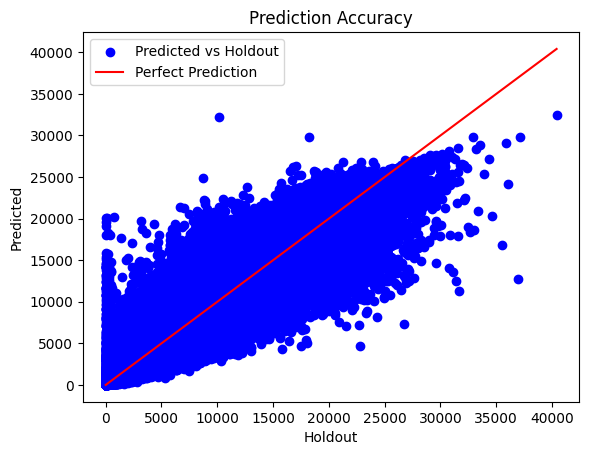

In [64]:
import matplotlib.pyplot as plt

# Plot the predicted values against the holdout values
plt.scatter(df_predictions['Holdout'], df_predictions['Predicted'], c='blue', label='Predicted vs Holdout')

# Add a reference line
plt.plot([df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], [df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], c='red', label='Perfect Prediction')

# Set labels and title
plt.xlabel('Holdout')
plt.ylabel('Predicted')
plt.title('Prediction Accuracy')

# Show the legend
plt.legend()

# Display the plot
plt.show()



In [22]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [23]:
from tabulate import tabulate

# Prompt the user for input
# truck_id = int(input("Enter the Truck ID: "))
# month = int(input("Enter the Month: "))
# day = int(input("Enter the Day: "))

# INPUT VALIDATION
# Prompt the user for input and perform input validation
'''
while True:
    try:
        truck_id = int(input("Enter the Truck ID (between 16 and 75): "))
        if not (16 <= truck_id <= 75):
            raise ValueError("Truck ID must be between 16 and 75")
        
        month = int(input("Enter the Month (1-12): "))
        if not (1 <= month <= 12):
            raise ValueError("Month must be between 1 and 12")
        
        if month in [1, 3, 5, 7, 8, 10, 12]:
            day_limit = 31
        elif month in [4, 6, 9, 11]:
            day_limit = 30
        elif month == 2:
            day_limit = 28
        else:
            raise ValueError("Invalid month")
        
        day = int(input(f"Enter the Day (1-{day_limit}): "))
        if not (1 <= day <= day_limit):
            raise ValueError(f"Day must be between 1 and {day_limit}")
        
        break
    
    except ValueError as e:
        print("Invalid input:", e)
'''

# Specify the criteria for filtering
truck_id = 43
month = 8
day = 25

# Filter the DataFrame for the specified criteria
filtered_df = df_predictions[(df_predictions['TRUCK_ID'] == truck_id) &
                             (df_predictions['MONTH'] == month) &
                             (df_predictions['DAY'] == day)]

# Sort the DataFrame by HOUR and Predicted values
sorted_df = filtered_df.sort_values(['HOUR', 'Predicted'], ascending=[True, False])

# Initialize a list to hold the table rows
table_rows = []

# Loop through each hour
for hour in sorted_df['HOUR'].unique():
    # Filter the DataFrame for the current hour
    hour_df = sorted_df[sorted_df['HOUR'] == hour]

    # Get the holdout values, predicted values, and best location ID for the current hour
    holdout_values = hour_df['Holdout'].tolist()
    predicted_values = hour_df['Predicted'].tolist()
    best_location_id = hour_df['LOCATION_ID'].iloc[0]
    possible_location_ids = hour_df['LOCATION_ID'].unique().tolist()

    # Append the row to the table_rows list
    table_rows.append([hour, best_location_id, possible_location_ids, holdout_values, predicted_values])

# Create a DataFrame from the table_rows list
df_best_loc_id = pd.DataFrame(table_rows, columns=["Hour", "Best Location ID", "Possible Location IDs", "Holdout Values", "Predicted Values"])



In [26]:
 import pyfiglet
# from termcolor import colored

# Create a Figlet object for ASCII art text
figlet = pyfiglet.Figlet(font='ogre')


# Convert the truck ID, month, and day to string
truck_id_str = str(truck_id)
month_str = str(month)
day_str = str(day)

# Concatenate the ASCII art and numbers in one row
art_row = ' '.join([
    figlet.renderText("Truck ID: " + truck_id_str + " Month: " + month_str + " Day: " + day_str)
])

# Print the ASCII art row
print(art_row)

# Print the DataFrame
df_best_loc_id


 _____                 _       _____  ___     _  _  _____ 
/__   \_ __ _   _  ___| | __   \_   \/   \_  | || ||___ / 
  / /\/ '__| | | |/ __| |/ /    / /\/ /\ (_) | || |_ |_ \ 
 / /  | |  | |_| | (__|   <  /\/ /_/ /_// _  |__   _|__) |
 \/   |_|   \__,_|\___|_|\_\ \____/___,' (_)    |_||____/ 
                                                          
                    _   _          ___       ___                ____  ____  
  /\/\   ___  _ __ | |_| |__  _   ( _ )     /   \__ _ _   _ _  |___ \| ___| 
 /    \ / _ \| '_ \| __| '_ \(_)  / _ \    / /\ / _` | | | (_)   __) |___ \ 
/ /\/\ \ (_) | | | | |_| | | |_  | (_) |  / /_// (_| | |_| |_   / __/ ___) |
\/    \/\___/|_| |_|\__|_| |_(_)  \___/  /___,' \__,_|\__, (_) |_____|____/ 
                                                      |___/                 



,Hour,Best Location ID,Possible Location IDs,Holdout Values,Predicted Values
0,8,15043,[15043],[2014.0],[8009.9225]
1,14,15043,[15043],[2206.0],[2349.34]
2,17,5176,[5176],"[6274.0, 6274.0]","[9244.89625, 9244.89625]"
3,21,5176,[5176],[7990.0],[8406.89375]


In [27]:
filtered_df

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,LAT,LONG,LOCATION_ID,SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,...,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED,Holdout,Predicted,Difference
208695,43,8,17,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,6274.0,9244.89625,2970.89625
303074,43,8,14,4,25,0,47.677944,-122.397465,15043,-0.002259,...,0,0,0,0,0,1,0,2206.0,2349.34000,143.34000
303068,43,8,8,4,25,0,47.677944,-122.397465,15043,-0.002259,...,0,0,0,0,0,1,0,2014.0,8009.92250,5995.92250
208699,43,8,21,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,7990.0,8406.89375,416.89375
208393,43,8,17,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,6274.0,9244.89625,2970.89625


In [28]:
# Get unique location IDs
unique_location_ids = df_predictions['LOCATION_ID'].unique()
print("Unique Location IDs:", unique_location_ids)

# Create a list to store the table data
table_data = []


# Create a DataFrame to store the table data
df_unique_locations_lat_long = pd.DataFrame(columns=["Location ID", "Latitude", "Longitude"])

# Iterate over each unique location ID
for location_id in unique_location_ids:
    location = df_predictions[df_predictions['LOCATION_ID'] == location_id]
    latitude = location['LAT'].values[0]
    longitude = location['LONG'].values[0]
    df_unique_locations_lat_long = pd.concat([df_unique_locations_lat_long, pd.DataFrame({"Location ID": [location_id],
                                                  "Latitude": [latitude],
                                                  "Longitude": [longitude]})],
                         ignore_index=True)

    

# Print the DataFrame
df_unique_locations_lat_long


Unique Location IDs: [15284  1675 15088 ... 15085 14897  3651]


,Location ID,Latitude,Longitude
0,15284,42.247702,-71.129438
1,1675,47.605014,-122.336302
2,15088,47.588769,-122.380905
3,4135,40.710351,-74.010756
4,5173,47.575333,-122.416758
...,...,...,...
1873,10893,40.800868,-73.959873
1874,2414,47.612053,-122.312236
1875,15085,47.563518,-122.404177
1876,14897,39.689947,-104.997897


### CONVERT TO FUNCTION

In [29]:
import math
import pandas as pd

def calculate_distances(df_predictions, starting_location_id):
    def haversine_distance(lat1, lon1, lat2, lon2):
        # Convert latitude and longitude from degrees to radians
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)

        # Haversine formula
        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad
        a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = 6371 * c  # Radius of the Earth in kilometers
        return distance

    # Find the reference location based on the starting location ID
    reference_location = df_predictions[df_predictions['LOCATION_ID'] == starting_location_id]
    reference_latitude = reference_location['LAT'].values[0]
    reference_longitude = reference_location['LONG'].values[0]

    # List of other locations with their respective location IDs, latitudes, and longitudes
    other_locations = df_predictions[['LOCATION_ID', 'LAT', 'LONG']].drop_duplicates().values.tolist()

    # Calculate distances between starting location and other locations
    distances = []
    for location in other_locations:
        location_id = location[0]
        latitude = location[1]
        longitude = location[2]
        distance = haversine_distance(reference_latitude, reference_longitude, latitude, longitude)
        distances.append({'Location_ID_start': starting_location_id, 'Location_ID_end': location_id, 'distance': distance})

    # Create a DataFrame from the distances list
    df_distances = pd.DataFrame(distances)

    # Sort the DataFrame by distance in ascending order
    df_distances = df_distances.sort_values('distance')

    return df_distances

# Example usage
reference_location_id = 5176
df_distances = calculate_distances(df_predictions, reference_location_id)
print(f"Distances from Location ID {reference_location_id}:")
df_distances


Distances from Location ID 5176:


,Location_ID_start,Location_ID_end,distance
500,5176,5176.0,0.000000
506,5176,2762.0,0.926345
208,5176,3003.0,0.963089
1113,5176,5174.0,1.191913
1649,5176,15086.0,1.195572
...,...,...,...
1167,5176,3731.0,4010.418755
1636,5176,15226.0,4013.935552
1298,5176,15221.0,4015.038004
42,5176,5236.0,4015.471760


In [30]:
from xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate= 0.04, max_depth= 10, n_estimators= 1700, subsample= 0.9)
xgb.fit(X_train, y_train)

# Create a DataFrame with holdout values and predicted values
df_predictions = X_holdout.copy()
df_predictions['Holdout'] = y_holdout
holdout_predictions = xgb.predict(X_holdout)
df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Print the DataFrame
print(df_predictions)


c:\Users\Nathan\anaconda3\envs\py38_env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\Users\Nathan\anaconda3\envs\py38_env\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


KeyboardInterrupt: 

In [31]:
import numpy as np

# Specify the criteria for filtering
truck_id = 43
month = 8
day = 25

columns_to_exclude = ['AVG_TEMPERATURE_AIR_2M_F', 'AVG_TEMPERATURE_HEATINDEX_2M_F', 'TOT_PRECIPITATION_IN', 'TOT_SNOWFALL_IN', 'TOT_SNOWDEPTH_IN', 'AVG_CLOUD_COVER_TOT_PCT']

# Create a DataFrame with holdout values and predicted values
df_predictions = X_final_scaled.drop("Profit",axis=1)
holdout_predictions = rf.predict(df_predictions)
df_predictions['Holdout'] = X_final_scaled[["Profit"]]

df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Filter the DataFrame for the specified criteria
filtered_df = df_predictions[(df_predictions['TRUCK_ID'] == truck_id) &
                             (df_predictions['MONTH'] == month) &
                             (df_predictions['DAY'] == day)]

# Sort the DataFrame by HOUR and Predicted values
sorted_df = filtered_df.sort_values(['HOUR', 'Predicted'], ascending=[True, False])

# Initialize a list to hold the table rows
table_rows = []

# Loop through each hour
for hour in sorted_df['HOUR'].unique():
    # Filter the DataFrame for the current hour
    hour_df = sorted_df[sorted_df['HOUR'] == hour]

    # Get the holdout values, predicted values, and best location ID for the current hour
    holdout_values = hour_df['Holdout'].tolist()
    predicted_values = hour_df['Predicted'].tolist()
    best_location_id = hour_df['LOCATION_ID'].iloc[0]

    # Filter distances DataFrame for distances less than 4 km from location_id 5176.0
    filtered_distances = df_distances[(df_distances['Location_ID_start'] == 5176.0) & (df_distances['distance'] < 4.0)]

    # Get the possible location IDs including the newly added location IDs
    possible_location_ids = sorted(set(hour_df['LOCATION_ID'].unique()) | set(filtered_distances['Location_ID_end'].unique()))

    # Initialize a list to hold the predicted values for each possible location ID
    predicted_values_per_location = []

    # Loop through each possible location ID
    for location_id_end in possible_location_ids:
        # Filter the DataFrame for the current location ID
        location_df = hour_df[hour_df['LOCATION_ID'] == location_id_end]

        # If there are records for the current location ID, append the predicted value
        if not location_df.empty:
            predicted_value = location_df['Predicted'].iloc[0]
        else:
            predicted_value = 0  # Default predicted value if no records exist for the current location ID

        predicted_values_per_location.append(predicted_value)

    # Append the row to the table_rows list
    table_rows.append([hour, best_location_id, possible_location_ids, holdout_values, predicted_values, predicted_values_per_location])

# Create a DataFrame from the table_rows list
df_best_loc_id = pd.DataFrame(table_rows, columns=["Hour", "Best Location ID", "Possible Location IDs", "Holdout Values", "Predicted Values", "Predicted Values per Location"])


In [32]:
df_best_loc_id

,Hour,Best Location ID,Possible Location IDs,Holdout Values,Predicted Values,Predicted Values per Location
0,8,15043,"[1085.0, 1088.0, 1266.0, 1330.0, 1362.0, 1580....","[2014.0, 6776.0]","[8009.9225, 6083.975]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6083.975, 0,..."
1,9,2321,"[1085.0, 1088.0, 1266.0, 1330.0, 1362.0, 1580....","[11016.0, 8306.0]","[10728.32375, 8991.78]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10728.32375,..."
2,10,15043,"[1085.0, 1088.0, 1266.0, 1330.0, 1362.0, 1580....","[8046.0, 6240.0]","[6883.72125, 6124.0825]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6124.0825, 0..."
3,11,2321,"[1085.0, 1088.0, 1266.0, 1330.0, 1362.0, 1580....","[8790.0, 8668.0]","[7607.54, 5228.40625]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7607.54, 0, ..."
4,12,15043,"[1085.0, 1088.0, 1266.0, 1330.0, 1362.0, 1580....","[9260.0, 6490.0]","[9796.255, 7912.155]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7912.155, 0,..."
5,13,2321,"[1085.0, 1088.0, 1266.0, 1330.0, 1362.0, 1580....","[10496.0, 4194.0]","[9153.12125, 5115.6575]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9153.12125, ..."
6,14,15043,"[1085.0, 1088.0, 1266.0, 1330.0, 1362.0, 1580....",[2206.0],[2349.34],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,15,5176,"[1085.0, 1088.0, 1266.0, 1330.0, 1362.0, 1580....","[3594.0, 3594.0, 1792.0]","[3341.92, 3341.92, 2307.96125]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,16,15110,"[1085.0, 1088.0, 1266.0, 1330.0, 1362.0, 1580....","[4988.0, 3566.0, 3566.0]","[4682.23375, 3838.5825, 3838.5825]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,17,5176,"[1085.0, 1088.0, 1266.0, 1330.0, 1362.0, 1580....","[6274.0, 6274.0, 7248.0]","[9244.89625, 9244.89625, 8637.25625]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [33]:
import numpy as np

# Specify the criteria for filtering
truck_id = 43
month = 8
day = 25

# Create a DataFrame with holdout values and predicted values
df_predictions = X_final_scaled.drop("Profit",axis=1)
holdout_predictions = rf.predict(df_predictions)
df_predictions['Holdout'] = X_final_scaled[["Profit"]]

df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Filter the DataFrame for the specified criteria
filtered_df = df_predictions[(df_predictions['TRUCK_ID'] == truck_id) &
                             (df_predictions['MONTH'] == month) &
                             (df_predictions['DAY'] == day)]


# Sort the DataFrame by HOUR and Predicted values
sorted_df = filtered_df.sort_values(['HOUR', 'Predicted'], ascending=[True, False])

# Initialize a list to hold the table rows
table_rows = []

# Filter distances DataFrame for distances less than 4 km from location_id 5176.0
filtered_distances = df_distances[(df_distances['Location_ID_start'] == 5176.0) & (df_distances['distance'] < 4.0)]

# Get unique location IDs from the filtered distances DataFrame
all_location_ids = filtered_distances['Location_ID_end'].unique()

# Loop through each hour
for hour in sorted_df['HOUR'].unique():
    # Filter the DataFrame for the current hour
    hour_df = sorted_df[sorted_df['HOUR'] == hour]

    # Duplicate rows for each possible location ID
    duplicated_df = hour_df.loc[hour_df.index.repeat(len(all_location_ids))]
    duplicated_df['LOCATION_ID'] = np.tile(all_location_ids, len(hour_df))

    # Select only the relevant features for prediction
    X_new = duplicated_df.drop(columns=['Difference', 'Holdout', 'Predicted'])

    # Predict on the new rows with possible location IDs
    new_predictions = rf.predict(X_new)
    duplicated_df['Predicted'] = new_predictions

    # Loop through each row in the duplicated DataFrame
    for _, row in duplicated_df.iterrows():
        # Get the location ID, holdout values, and predicted values for the current row
        location_id = row['LOCATION_ID']
        holdout_values = row['Holdout']
        predicted_values = row['Predicted']

        # Append the row to the table_rows list
        table_rows.append([hour, location_id, holdout_values, predicted_values])

# Create a DataFrame from the table_rows list
df_predictions_per_hour_location = pd.DataFrame(table_rows, columns=["Hour", "Location ID", "Holdout Values", "Predicted Values"])


In [34]:
df_predictions_per_hour_location.head(30)

,Hour,Location ID,Holdout Values,Predicted Values
0,8,5176.0,2014.0,8154.21375
1,8,2762.0,2014.0,7846.41000
2,8,3003.0,2014.0,7854.74000
3,8,5174.0,2014.0,8154.21375
4,8,15086.0,2014.0,7985.92875
5,8,2272.0,2014.0,8255.67375
6,8,15096.0,2014.0,8026.67875
7,8,15097.0,2014.0,8026.67875
8,8,2294.0,2014.0,8219.22375
9,8,15081.0,2014.0,7975.74875


In [35]:
# Print the DataFrame
print("Truck ID:", truck_id)
print("Month:", month)
print("Day:", day)
print("------------------------------------")
df_predictions_per_hour_location

Truck ID: 43
Month: 8
Day: 25
------------------------------------


,Hour,Location ID,Holdout Values,Predicted Values
0,8,5176.0,2014.0,8154.21375
1,8,2762.0,2014.0,7846.41000
2,8,3003.0,2014.0,7854.74000
3,8,5174.0,2014.0,8154.21375
4,8,15086.0,2014.0,7985.92875
...,...,...,...,...
1395,22,1362.0,1886.0,1770.25875
1396,22,2323.0,1886.0,1744.93375
1397,22,2559.0,1886.0,1778.10625
1398,22,3965.0,1886.0,1799.69000


In [36]:
import pandas as pd

pd.options.mode.chained_assignment = None

# Create a new DataFrame to store all rows for location_df
Best_loc_df = pd.DataFrame()

# Loop through each hour
for hour in df_predictions_per_hour_location['Hour'].unique():
    print(f"Hour: {hour}")

    # Filter the DataFrame for the current hour
    hour_df = df_predictions_per_hour_location[df_predictions_per_hour_location['Hour'] == hour]

    # Loop through each location ID
    for location_id in hour_df['Location ID'].unique():
        # Filter the DataFrame for the current hour and location ID
        location_df = hour_df[hour_df['Location ID'] == location_id]

        # Calculate the average predicted value for the current hour and location ID
        average_predicted_value = location_df['Predicted Values'].mean()

        # Update the location_df with the mean predicted values
        location_df.loc[:, 'Average Predicted Value'] = average_predicted_value

        # Append the rows for location_df to the all_rows_df DataFrame
        Best_loc_df = pd.concat([Best_loc_df, location_df])

        print(f"Location ID: {location_id}, Average Predicted Value: {average_predicted_value}")

pd.options.mode.chained_assignment = 'warn'


Hour: 8
Location ID: 5176.0, Average Predicted Value: 7133.411875
Location ID: 2762.0, Average Predicted Value: 6825.02625
Location ID: 3003.0, Average Predicted Value: 6872.93625
Location ID: 5174.0, Average Predicted Value: 7133.411875
Location ID: 15086.0, Average Predicted Value: 7257.68375
Location ID: 2272.0, Average Predicted Value: 7113.124374999999
Location ID: 15096.0, Average Predicted Value: 7265.5337500000005
Location ID: 15097.0, Average Predicted Value: 7265.5337500000005
Location ID: 2294.0, Average Predicted Value: 7096.144375
Location ID: 15081.0, Average Predicted Value: 7252.59375
Location ID: 15095.0, Average Predicted Value: 7265.5337500000005
Location ID: 15088.0, Average Predicted Value: 7239.49375
Location ID: 3673.0, Average Predicted Value: 7252.24625
Location ID: 15079.0, Average Predicted Value: 7252.59375
Location ID: 15083.0, Average Predicted Value: 7257.68375
Location ID: 1088.0, Average Predicted Value: 6741.2275
Location ID: 2120.0, Average Predicted 

In [37]:
Best_loc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400 entries, 0 to 1399
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hour                     1400 non-null   int8   
 1   Location ID              1400 non-null   float64
 2   Holdout Values           1400 non-null   float64
 3   Predicted Values         1400 non-null   float64
 4   Average Predicted Value  1400 non-null   float64
dtypes: float64(4), int8(1)
memory usage: 56.1 KB


In [38]:
# Loop through each hour
for hour in Best_loc_df['Hour'].unique():
    print(f"Hour: {hour}")

    # Filter the DataFrame for the current hour
    hour_df = Best_loc_df[Best_loc_df['Hour'] == hour]

    # Find the location with the largest average predicted value for the current hour
    max_avg_predicted = hour_df['Average Predicted Value'].max()
    best_location_id = hour_df.loc[hour_df['Average Predicted Value'] == max_avg_predicted, 'Location ID'].values[0]

    print(f"Location ID: {best_location_id}, Largest Average Predicted Value: {max_avg_predicted}")

    print()


Hour: 8
Location ID: 3674.0, Largest Average Predicted Value: 7280.173124999999

Hour: 9
Location ID: 8410.0, Largest Average Predicted Value: 10044.485625

Hour: 10
Location ID: 15088.0, Largest Average Predicted Value: 6566.324375

Hour: 11
Location ID: 2323.0, Largest Average Predicted Value: 6424.07875

Hour: 12
Location ID: 3965.0, Largest Average Predicted Value: 9772.098125

Hour: 13
Location ID: 2323.0, Largest Average Predicted Value: 7397.4506249999995

Hour: 14
Location ID: 2120.0, Largest Average Predicted Value: 2861.72

Hour: 15
Location ID: 1085.0, Largest Average Predicted Value: 3126.2533333333336

Hour: 16
Location ID: 15107.0, Largest Average Predicted Value: 4220.674583333333

Hour: 17
Location ID: 1808.0, Largest Average Predicted Value: 9412.433333333332

Hour: 18
Location ID: 15087.0, Largest Average Predicted Value: 10795.228333333333

Hour: 19
Location ID: 1266.0, Largest Average Predicted Value: 11933.580416666666

Hour: 20
Location ID: 1266.0, Largest Average

In [39]:
Best_loc_df = Best_loc_df.drop_duplicates()
Best_loc_df.head()

,Hour,Location ID,Holdout Values,Predicted Values,Average Predicted Value
0,8,5176.0,2014.0,8154.21375,7133.411875
40,8,5176.0,6776.0,6112.61000,7133.411875
1,8,2762.0,2014.0,7846.41000,6825.026250
41,8,2762.0,6776.0,5803.64250,6825.026250
2,8,3003.0,2014.0,7854.74000,6872.936250


In [44]:
filtered_df

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,LAT,LONG,LOCATION_ID,SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,...,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED,Holdout,Predicted,Difference
208391,43,8,15,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,3594.0,3341.92000,-252.08000
208392,43,8,16,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,3566.0,3838.58250,272.58250
208393,43,8,17,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,6274.0,9244.89625,2970.89625
208394,43,8,18,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,10488.0,10272.08750,-215.91250
208395,43,8,19,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,10344.0,10231.00000,-113.00000
208396,43,8,20,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,9248.0,9319.82500,71.82500
208397,43,8,21,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,7990.0,8406.89375,416.89375
208693,43,8,15,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,3594.0,3341.92000,-252.08000
208694,43,8,16,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,3566.0,3838.58250,272.58250
208695,43,8,17,3,25,0,47.573410,-122.375880,5176,0.397856,...,0,0,0,0,0,1,0,6274.0,9244.89625,2970.89625


Hour: 8
Location ID: 3674.0, New Value gained: 7280.173124999999
Holdout Value: 2014.0
Additional Value: 5266.173124999999
Hour: 9
Location ID: 8410.0, New Value gained: 10044.485625
Holdout Value: 8306.0
Additional Value: 1738.4856249999993
Hour: 10
Location ID: 15088.0, New Value gained: 6566.324375
Holdout Value: 8046.0
Additional Value: -1479.6756249999999
Hour: 11
Location ID: 2323.0, New Value gained: 6424.07875
Holdout Value: 8668.0
Additional Value: -2243.9212500000003
Hour: 12
Location ID: 3965.0, New Value gained: 9772.098125
Holdout Value: 9260.0
Additional Value: 512.0981250000004
Hour: 13
Location ID: 2323.0, New Value gained: 7397.4506249999995
Holdout Value: 4194.0
Additional Value: 3203.4506249999995
Hour: 14
Location ID: 2120.0, New Value gained: 2861.72
Holdout Value: 2206.0
Additional Value: 655.7199999999998
Hour: 15
Location ID: 1085.0, New Value gained: 3126.2533333333336
Holdout Value: 3594.0
Additional Value: -467.74666666666644
Hour: 16
Location ID: 15107.0, Ne

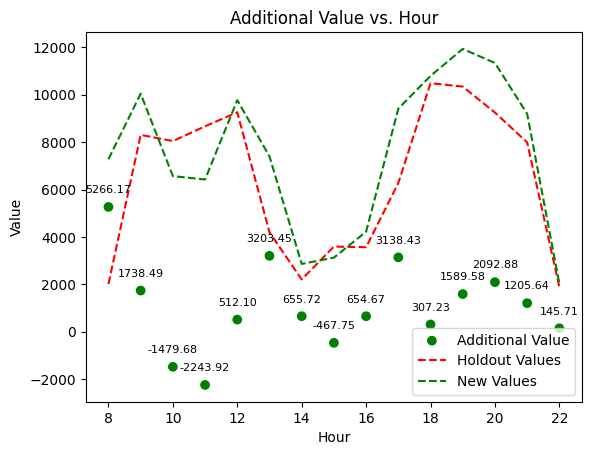

In [63]:
import matplotlib.pyplot as plt

x_values = []
y_values = []
holdout_values = []
new_values = []
colors = []

previous_location_id = 5176

# Loop through each hour
for hour in Best_loc_df['Hour'].unique():
    print(f"Hour: {hour}")

    # Filter the DataFrame for the current hour
    hour_df = Best_loc_df[Best_loc_df['Hour'] == hour]

    # Find the location with the largest average predicted value for the current hour
    max_avg_predicted = hour_df['Average Predicted Value'].max()
    best_location_id = hour_df.loc[hour_df['Average Predicted Value'] == max_avg_predicted, 'Location ID'].values[0]

    print(f"Location ID: {best_location_id}, New Value gained: {max_avg_predicted}")

    # # Get the corresponding holdout value for the best location
    holdout_value = filtered_df[(filtered_df['HOUR'] == hour)]
    hour_value = holdout_value['Holdout'].values[0]

    print(f"Holdout Value: {hour_value}")

    additional_value = max_avg_predicted - hour_value
    
    # print(type(additional_value), type(holdout_value), type(max_avg_predicted))
    print(f"Additional Value: {additional_value}")

    # Append the hour and additional value to the x and y value lists
    x_values.append(hour)
    y_values.append(additional_value)

    # Append the holdout value and new value to the respective lists
    holdout_values.append(hour_value)
    new_values.append(max_avg_predicted)

    # Check if the location has changed and assign colors accordingly
    if best_location_id == holdout_value['LOCATION_ID'].values[0]:
        colors.append('red')
    else:
        colors.append('green')

    # Display the numerical value as annotation
    plt.annotate(f'{additional_value:.2f}', (hour, additional_value), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=8)

# Plot the values
plt.scatter(x_values, y_values, c=colors, label='Additional Value')
plt.plot(x_values, holdout_values, color='red', linestyle='--', label='Holdout Values')
plt.plot(x_values, new_values, color='green', linestyle='--', label='New Values')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.title('Additional Value vs. Hour')
plt.legend()
plt.show()
